In [ ]:
import pdb
import os
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import numpy as np
from PIL import Image

In [ ]:
import os
import random
from tqdm import tqdm
from shutil import copyfile

In [ ]:
base_path = "/content/drive/MyDrive/DL/final_project/pix2code"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Hyperparams
batch_size = 4
embed_size = 256
num_epochs = 100
learning_rate = 0.001
hidden_size = 512
num_layers = 1

# Other params
shuffle = True
num_workers = 2

# Logging Variables
save_after_x_epochs = 2
log_step = 1

# Paths
data_dir = base_path+'/datasets/web/processed_data/data_train/' 
model_path = base_path+'/model/'
vocab_path = base_path+'/bootstrap.vocab'
crop_size = 224 # Required by resnet152

In [ ]:
base_path

'/content/drive/MyDrive/DL/final_project/pix2code'

Load Data

In [ ]:
raw_data_dir = data_dir
output_dir = base_path+'/datasets/web/processed_data/'
filenames = os.listdir(raw_data_dir)

filenames = [(f[:-3] + 'gui', f[:-3] + 'png') for f in filenames if f.endswith('.gui')]

filenames.sort()
random.shuffle(filenames)

split_1 = int(0.8 * len(filenames))
split_2 = int(0.9 * len(filenames))

filenames = {
    'train': filenames[:split_1],
    'dev': filenames[split_1:split_2],
    'test': filenames[split_2:]
}

if not os.path.exists(output_dir):
    os.mkdir(output_dir)
else:
    print('Warning: output dir {} already exists.'.format(output_dir))

for split in ['train', 'dev', 'test']:
    output_dir_split = os.path.join(output_dir, 'data_{}'.format(split))
    
    if not os.path.exists(output_dir_split):
        os.mkdir(output_dir_split)
    else:
        print('Warning: output dir {} already exists.'.format(output_dir_split))
        
    print('Processing {} data, saving to {}.'.format(split, output_dir_split))
    
    for (gui, png) in tqdm(filenames[split]):
        src_path_gui = os.path.join(raw_data_dir, gui)
        output_path_gui = os.path.join(output_dir_split, gui)
        src_path_png = os.path.join(raw_data_dir, png)
        output_path_png = os.path.join(output_dir_split, png)
        
        copyfile(src_path_gui, output_path_gui)
        copyfile(src_path_png, output_path_png)

Build Vocab

In [ ]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [ ]:
class Vocabulary (object):
    def __init__ (self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        
    def add_word (self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    
    def __call__ (self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    
    def __len__ (self):
        return len(self.word2idx)

In [ ]:
def build_vocab (vocab_file_path):
    vocab = Vocabulary()

    words_raw = load_doc(vocab_file_path)
    words = set(words_raw.split(' '))
    
    for i, word in enumerate(words):
        vocab.add_word(word)

    vocab.add_word(' ')
    vocab.add_word('<unk>')
    
    print('Created vocabulary')
    
    return vocab

In [ ]:
vocab = build_vocab(vocab_path)
vocab_size = len(vocab)

Created vocabulary


Build Images and Captions

In [ ]:
class ImageHTMLDataSet (Dataset):
    def __init__ (self, data_dir, vocab, transform):
        self.data_dir = data_dir
        self.vocab = vocab
        self.transform = transform
        
        self.raw_image_names = []
        self.raw_captions = []
        
        self.filenames = os.listdir(data_dir)
        self.filenames.sort()
        
        for filename in self.filenames:
            if filename[-3:] == 'png':
                self.raw_image_names.append(filename)
            elif filename[-3:] == 'gui':
                data = load_doc(data_dir + filename)
                self.raw_captions.append(data)
                
        print('Created dataset of ' + str(len(self)) + ' items from ' + data_dir)

    def __len__ (self):
        return len(self.raw_image_names)
    
    def __getitem__ (self, idx):
        img_path, raw_caption = self.raw_image_names[idx], self.raw_captions[idx]
        
        image = Image.open(os.path.join(self.data_dir, img_path)).convert('RGB')
        image = self.transform(image)
        
        caption = []
        caption.append(self.vocab('<START>'))
        
        tokens = ' '.join(raw_caption.split())

        tokens = tokens.replace(',', ' ,')

        tokens = tokens.split(' ')
        
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab('<END>'))
        
        target = torch.Tensor(caption)
        
        return image, target

def collate_fn (data):
    data.sort(key = lambda data_pair: len(data_pair[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)
    
    lengths = [len(caption) for caption in captions] 
    targets = torch.zeros(len(captions), max(lengths)).long()
    
    for i, caption in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = caption[:end]
        
    return images, targets, lengths

In [ ]:
transform = transforms.Compose([
    transforms.Resize((crop_size, crop_size)), #resnet size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_html_dataset = ImageHTMLDataSet(data_dir=data_dir, vocab=vocab, transform=transform)
data_loader = DataLoader(dataset=img_html_dataset,
                         batch_size=batch_size,
                         shuffle=shuffle,
                         num_workers=num_workers,
                         collate_fn=collate_fn,drop_last=True)

Created dataset of 1393 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_train/


Encoder

In [ ]:
class EncoderCNN (nn.Module):
    def __init__ (self, embed_size):
        super(EncoderCNN, self).__init__()
        
        resnet = models.resnet152(pretrained = True)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        self.linear = nn.Linear(in_features = resnet.fc.in_features, out_features = embed_size)
        self.bn = nn.BatchNorm1d(num_features = embed_size, momentum = 0.01)
        
        print('Encoder created' + str(embed_size))

    def forward (self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)        
        features = self.linear(features)        
        features = self.bn(features)        
        return features

In [ ]:
class DecoderRNN (nn.Module):
    def __init__ (self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        
        self.embed = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_size)
        self.lstm = nn.LSTM(input_size = embed_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(in_features = hidden_size, out_features = vocab_size)        
        self.embed_size = embed_size        
        print('Decoder created.')
        
    def forward (self, features, captions, lengths):
        embeddings = self.embed(captions)
        
        features = features.unsqueeze(1) 
        
        embeddings = torch.cat((features, embeddings), 1)
        
        packed = nn.utils.rnn.pack_padded_sequence(input = embeddings, lengths = lengths, batch_first = True)
        
        hiddens, _ = self.lstm(packed)
        
        outputs = self.linear(hiddens[0])
        
        return outputs

    def sample (self, features,greedy=False,states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        
        if greedy:
          iters=1
        else:
          iters=100

        for i in range(iters):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            predicted = outputs.max(dim = 1, keepdim = True)[1]
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.view(-1, 1, self.embed_size)

        sampled_ids = torch.cat(sampled_ids, 1)

        return sampled_ids.squeeze()

In [ ]:
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr = learning_rate)

if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()
    print('CUDA activated.')

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Encoder created256
Decoder created.
CUDA activated.


In [ ]:
import time

In [ ]:
from collections import defaultdict
history = defaultdict()

In [ ]:
history['loss'] = []
history['perp'] = []
history['time'] = []

In [ ]:
encoder.train()
decoder.train()

start_time = time.time()
batch_count = len(data_loader)

for epoch in range(30):
    for i, (images, captions, lengths) in enumerate(data_loader):
        images = Variable(images.cuda())
        captions = Variable(captions.cuda())
        targets = nn.utils.rnn.pack_padded_sequence(input = captions, lengths = lengths, batch_first = True)[0]

        encoder.zero_grad()
        decoder.zero_grad()

        features = encoder(images) 
        outputs = decoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()

        if epoch % log_step == 0 and i == 0:
            history['loss'].append(loss.item())
            history['perp'].append(np.exp(loss.item()))
            history['time'].append(time.time())
            print('Epoch - #%d, Loss: %.4f, Perplexity: %5.4f'
                  % (epoch, loss.item(), np.exp(loss.item())))
            
        if (epoch + 1) % save_after_x_epochs == 0 and i == 0:
            # Save our models
            print('Saving model: ' + str(epoch))
            torch.save(decoder.state_dict(),os.path.join(model_path, 'decoder-hp1-%d-%d.pkl' %(epoch+1, i+1)))
            torch.save(encoder.state_dict(), os.path.join(model_path, 'encoder-hp1-%d-%d.pkl' %(epoch+1, i+1)))

Epoch - #0, Loss: 2.9563, Perplexity: 19.2269
Epoch - #1, Loss: 0.1815, Perplexity: 1.1990
Saving model: 1
Epoch - #2, Loss: 0.1815, Perplexity: 1.1991
Epoch - #3, Loss: 0.1591, Perplexity: 1.1724
Saving model: 3
Epoch - #4, Loss: 0.1516, Perplexity: 1.1637
Epoch - #5, Loss: 0.2176, Perplexity: 1.2431
Saving model: 5
Epoch - #6, Loss: 0.1363, Perplexity: 1.1460
Epoch - #7, Loss: 0.1408, Perplexity: 1.1512
Saving model: 7
Epoch - #8, Loss: 0.1429, Perplexity: 1.1536
Epoch - #9, Loss: 0.1268, Perplexity: 1.1352
Saving model: 9
Epoch - #10, Loss: 0.1477, Perplexity: 1.1591
Epoch - #11, Loss: 0.1522, Perplexity: 1.1644
Saving model: 11
Epoch - #12, Loss: 0.1275, Perplexity: 1.1360
Epoch - #13, Loss: 0.1098, Perplexity: 1.1160
Saving model: 13
Epoch - #14, Loss: 0.1322, Perplexity: 1.1413
Epoch - #15, Loss: 0.1160, Perplexity: 1.1230
Saving model: 15
Epoch - #16, Loss: 0.1213, Perplexity: 1.1289
Epoch - #17, Loss: 0.1041, Perplexity: 1.1098
Saving model: 17
Epoch - #18, Loss: 0.1205, Perple

Eval

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
def transform_idx_to_words (input):
    sampled_caption = []
    
    for idx in input:
        word = vocab.idx2word[idx]
        sampled_caption.append(word)

        if word == '<END>':
            break

    output = ' '.join(sampled_caption[1:-1])

    output = output.replace(' ,', ',')

    return output.split(' ')

In [ ]:
models_to_test = [str(i)+"-1" for i in range(2,31,2)]

In [ ]:
models_to_test

['2-1',
 '4-1',
 '6-1',
 '8-1',
 '10-1',
 '12-1',
 '14-1',
 '16-1',
 '18-1',
 '20-1',
 '22-1',
 '24-1',
 '26-1',
 '28-1',
 '30-1']

In [ ]:
dev_data_dir = base_path+'/datasets/web/processed_data/data_dev/'

In [ ]:
from collections import defaultdict

In [ ]:
bleu_scores = []
predicted=defaultdict(list)
actual=defaultdict(list)
for model_idx, model_name in enumerate(models_to_test):
    encoder_model_path = os.path.join(model_path, 'encoder-hp1-{}.pkl'.format(model_name))
    decoder_model_path = os.path.join(model_path, 'decoder-hp1-{}.pkl'.format(model_name))
    
    dev_img_html_dataset = ImageHTMLDataSet(data_dir=dev_data_dir, vocab=vocab, transform=transform)
    
    dev_data_loader = DataLoader(dataset=dev_img_html_dataset,
                             batch_size=1,
                             shuffle=shuffle,
                             num_workers=num_workers,
                             collate_fn=collate_fn, drop_last= True)
    
    dev_encoder = EncoderCNN(embed_size)
    dev_decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)

    dev_encoder.load_state_dict(torch.load(encoder_model_path))
    dev_decoder.load_state_dict(torch.load(decoder_model_path))

    if torch.cuda.is_available():
        dev_encoder.cuda()
        dev_decoder.cuda()

    dev_encoder.eval()
    dev_decoder.eval()
    
    dev_data_count = len(dev_data_loader.dataset)


    for i in range(dev_data_count):
        image, caption = dev_data_loader.dataset.__getitem__(i)
        image_tensor = Variable(image.unsqueeze(0).cuda())

        features = dev_encoder(image_tensor)

        sampled_ids = dev_decoder.sample(features)
        sampled_ids = sampled_ids.cpu().data.numpy()

        predicted[model_idx].append(sampled_ids)
        actual[model_idx].append(list(caption.numpy()))

    predicted[model_idx] = [transform_idx_to_words(item) for item in predicted[model_idx]]
    actual[model_idx] = [[transform_idx_to_words(item)] for item in actual[model_idx]]
    
    bleu = corpus_bleu(actual[model_idx], predicted[model_idx])
    
    bleu_scores.append((model_name, bleu))

    print('done with {} items for model: {}'.format(str(len(predicted[model_idx])), model_name))

Created dataset of 174 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_dev/
EncoderCNN created with embed_size: 256
DecoderRNN created with embed_size: 256


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


done with 174 items for model: 2-1
Created dataset of 174 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_dev/
EncoderCNN created with embed_size: 256
DecoderRNN created with embed_size: 256
done with 174 items for model: 4-1
Created dataset of 174 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_dev/
EncoderCNN created with embed_size: 256
DecoderRNN created with embed_size: 256
done with 174 items for model: 6-1
Created dataset of 174 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_dev/
EncoderCNN created with embed_size: 256
DecoderRNN created with embed_size: 256
done with 174 items for model: 8-1
Created dataset of 174 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_dev/
EncoderCNN created with embed_size: 256
DecoderRNN created with embed_size: 256
done with 174 items for model: 10-1
Created dataset of 1

In [ ]:
history['bleu'] = bleu_scores

In [ ]:
time_diff = [x - start_time for x in history['time']]

In [ ]:
history['epoch_time'] = time_diff

In [ ]:
import json

with open(base_path+'/saved_results_hp1.json','w') as f:
  json.dump(predicted,f)



In [ ]:
import matplotlib.pyplot as plt

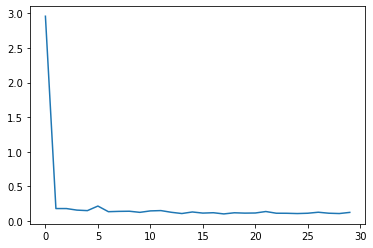

In [ ]:
plt.plot(history['loss'])

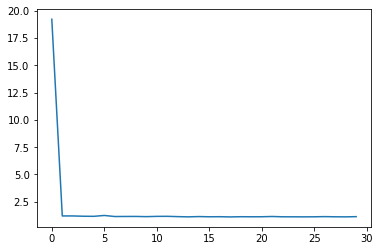

In [ ]:
plt.plot(history['perp'])

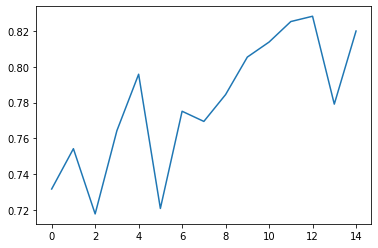

In [ ]:
plt.plot([x[1] for x in history['bleu']])

**TEST**

In [ ]:
test_data_dir =  base_path+'/datasets/web/processed_data/data_test/'
chosen_model = ['12-1']

In [ ]:
from collections import defaultdict

In [ ]:
bleu_scores = []

for model_idx, model_name in enumerate(chosen_model):
    encoder_model_path = os.path.join(model_path, 'encoder-hp1-{}.pkl'.format(model_name))
    decoder_model_path = os.path.join(model_path, 'decoder-hp1-{}.pkl'.format(model_name))
    
    dev_img_html_dataset = ImageHTMLDataSet(data_dir=test_data_dir, vocab=vocab, transform=transform)
    
    dev_data_loader = DataLoader(dataset=dev_img_html_dataset,
                             batch_size=1,
                             shuffle=shuffle,
                             num_workers=num_workers,
                             collate_fn=collate_fn)
    
    dev_encoder = EncoderCNN(embed_size)
    dev_decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)

    dev_encoder.load_state_dict(torch.load(encoder_model_path))
    dev_decoder.load_state_dict(torch.load(decoder_model_path))

    if torch.cuda.is_available():
        dev_encoder.cuda()
        dev_decoder.cuda()

    dev_encoder.eval()
    dev_decoder.eval()
    
    dev_data_count = len(dev_data_loader.dataset)

    predicted, actual = list(), list()
    bleu=0.
    for i, (images, captions, lengths) in enumerate(dev_data_loader):
      
        images = Variable(images.cuda())

        captions = Variable(captions.cuda())

        lengths = torch.tensor(lengths)

        dev_encoder.zero_grad()
        dev_decoder.zero_grad()
        
        features = dev_encoder(images) 
        scores = dev_decoder(features, captions, lengths)


        predicted = list(np.argmax(scores.data.detach().cpu().numpy(),axis=1))
        actual = list(captions.detach()[0].cpu().numpy())


        predicted = [vocab.idx2word[item] for item in predicted]
        actual = [vocab.idx2word[item] for item in actual]

    
        bleu+=corpus_bleu(actual, predicted)
    
    bleu_scores.append((model_name, bleu/len(dev_data_loader.dataset)))
                    
    print('done with {} items for model: {}'.format(str(len(predicted)), model_name))

Created dataset of 175 items from /content/drive/MyDrive/DL/final_project/pix2code/datasets/web/processed_data/data_test/
Encoder created256
Decoder created.


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


done with 77 items for model: 12-1


In [ ]:
bleu_scores

[('12-1', 0.7359383730173946)]